In [5]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import datetime

In [6]:
filepath = os.path.join('../data/', 'eagle_data_2023_02_22.pkl')
eagle_df = pd.read_pickle(filepath)

In [7]:
eagle_df.columns

Index(['user', 'account', 'partition', 'nodes_req', 'processors_req',
       'wallclock_req', 'qos', 'gpus_requested', 'name', 'submit_time',
       'job_id', 'wallclock_used', 'hours_used', 'state', 'start_time',
       'end_time', 'work_dir', 'submit_line', 'req_mem'],
      dtype='object')

In [8]:
len(eagle_df)

11215986

In [9]:
len(eagle_df.user.unique())

950

In [10]:
len(eagle_df.account.unique())

594

In [12]:
eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])].wallclock_used.max()

Timedelta('13 days 00:00:30')

In [13]:
eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])].nodes_req.max()

2100

In [14]:
eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])].wallclock_used.median()

Timedelta('0 days 00:16:13')

In [17]:
eagle_df['wallclock_used_seconds'] = filtered_df.wallclock_used.apply(lambda x: x.total_seconds())

In [45]:
filtered_df = eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])]

In [47]:
def bin_node_hours(v):
    if v <= 4:
        return "short"
    elif (v > 4) and (v <= 48):
        return "medium"
    else: 
        return "long"

node_hours_binned_labels = ["short", "medium", "long"]
filtered_df["node_hours_binned"] = filtered_df.hours_used.apply(bin_node_hours)

num_jobs_by_job_length = dict()

for idx, grp in filtered_df.groupby('node_hours_binned'):
    num_jobs_by_job_length[idx] = len(grp)
    
num_jobs_by_job_length_df = pd.DataFrame(\
zip(num_jobs_by_job_length.keys(),num_jobs_by_job_length.values()),\
columns=['job_length', 'num_jobs'])

node_hours_by_job_length = dict()

for idx, grp in filtered_df.groupby('node_hours_binned'):
    node_hours_by_job_length[idx] = grp['hours_used'].sum()
    
node_hours_by_job_length_df = pd.DataFrame(\
zip(node_hours_by_job_length.keys(),node_hours_by_job_length.values()),\
columns=['job_length', 'node_hours'])

num_jobs_by_job_length_sorted = num_jobs_by_job_length_df.sort_values('job_length')
node_hours_by_job_length_sorted = node_hours_by_job_length_df.sort_values('job_length')

num_jobs_and_node_hours_by_job_length = pd.concat([num_jobs_by_job_length_sorted,node_hours_by_job_length_sorted['node_hours']],axis=1).sort_values('node_hours')
num_jobs_and_node_hours_by_job_length

/var/folders/cy/yhfymg2j61gfl448mb_195qxlvt1vt/T/ipykernel_96512/4263330385.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["node_hours_binned"] = filtered_df.hours_used.apply(bin_node_hours)


,job_length,num_jobs,node_hours
2,short,6717169,3.638441e+06
1,medium,1358916,1.484994e+07
0,long,232019,4.476531e+07


In [23]:
(filtered_df['wallclock_used_seconds'] / 60).median()

16.216666666666665

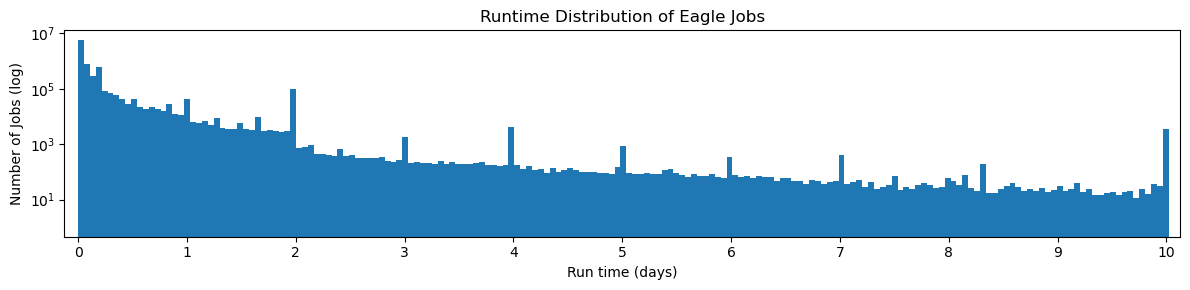

In [25]:
plt.figure(figsize=(12,3))
plt.hist(filtered_df['wallclock_used_seconds'] / 3600, bins=240)
plt.xlim([-3,243])
plt.xticks([0,24,48,72,96,120,144,168,192,216,240], labels=[0,1,2,3,4,5,6,7,8,9,10])
plt.yscale('log')
plt.xlabel('Run time (days)')
plt.ylabel('Number of Jobs (log)')
plt.title('Runtime Distribution of Eagle Jobs')
plt.tight_layout()
plt.savefig('runtime_distribution.jpg',dpi=300)
plt.show()

In [26]:
len(filtered_df[filtered_df['wallclock_used_seconds'] / 3600 < 1])

5586365

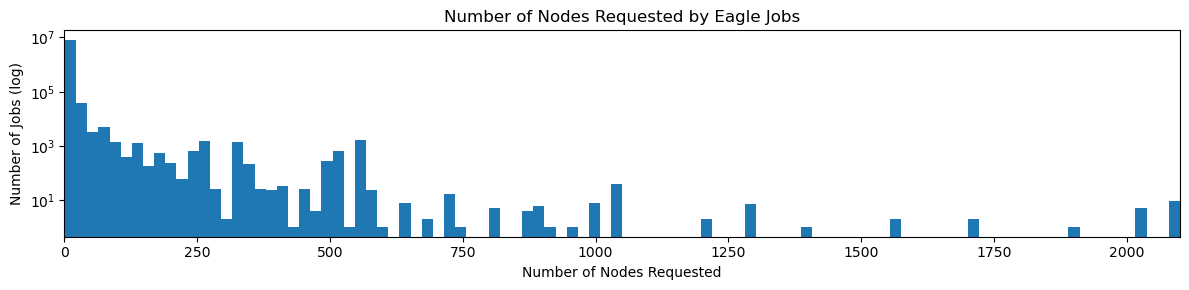

In [146]:
plt.figure(figsize=(12,3))
plt.hist(filtered_df['nodes_req'], bins=100)
plt.xlim([0,2100])
plt.yscale('log')
plt.xlabel('Number of Nodes Requested')
plt.ylabel('Number of Jobs (log)')
plt.title('Number of Nodes Requested by Eagle Jobs')
plt.tight_layout()
plt.savefig('nodes_req_distribution.jpg',dpi=300)
plt.show()

In [33]:
len(filtered_df[filtered_df['nodes_req'] > 1000])

69

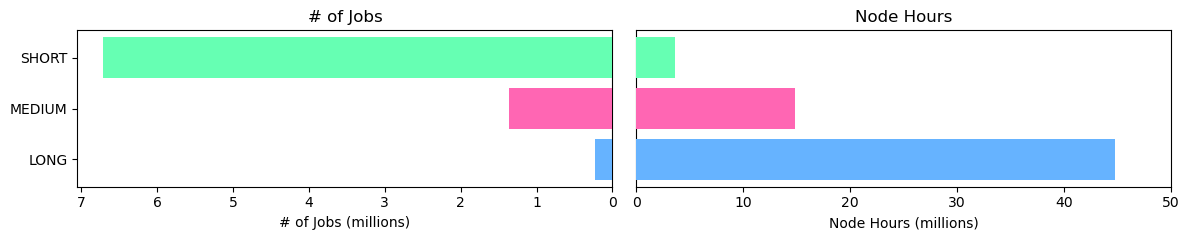

In [49]:
job_length = num_jobs_and_node_hours_by_job_length['job_length']

fig, axes = plt.subplots(figsize=(12,2.5), ncols=2, sharey=True)
fig.tight_layout()

colors = ['#66ffb3','#ff66b3','#66b3ff']
index = ['SHORT','MEDIUM','LONG']

axes[0].barh(index, num_jobs_and_node_hours_by_job_length['num_jobs'], align='center', color=colors, zorder=10)
axes[0].set_title("# of Jobs")
axes[0].invert_xaxis()
axes[0].yaxis.tick_left()

axes[1].barh(index, num_jobs_and_node_hours_by_job_length['node_hours'], align='center', color=colors, zorder=10)
axes[1].set_title("Node Hours")

labels_0 = ['0','1','2','3','4','5','6','7']
axes[0].set_xlabel("# of Jobs (millions)");
axes[0].set_xticks(list(range(0,7000001,1000000)))
axes[0].set_xticklabels(labels_0)

labels_1 = ['0','10','20','30','40','50']
axes[1].set_xlabel("Node Hours (millions)");
axes[1].set_xticks(list(range(0,50000001,10000000)))
axes[1].set_xticklabels(labels_1)
axes[1].tick_params(left=False)

plt.subplots_adjust(wspace=0.05, top=0.85, bottom=0.1, left=0.18, right=0.95)
plt.gca().invert_yaxis()

plt.tight_layout()
figure_name = "num_jobs_and_node_hours_by_job_size.png"
filepath = os.path.join('./', figure_name)
fig.savefig(filepath, dpi=300)

In [50]:
filtered_df['wc_factor'] = filtered_df.wallclock_req / filtered_df.wallclock_used

/var/folders/cy/yhfymg2j61gfl448mb_195qxlvt1vt/T/ipykernel_96512/2209348400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['wc_factor'] = filtered_df.wallclock_req / filtered_df.wallclock_used


In [51]:
filtered_df['wc_factor']

12          150.000000
13            1.818182
14            1.935484
15          100.000000
16          100.000000
               ...    
11215959      2.336579
11215960      2.285714
11215965      0.995025
11215968      0.993926
11215969     14.860681
Name: wc_factor, Length: 8308104, dtype: float64

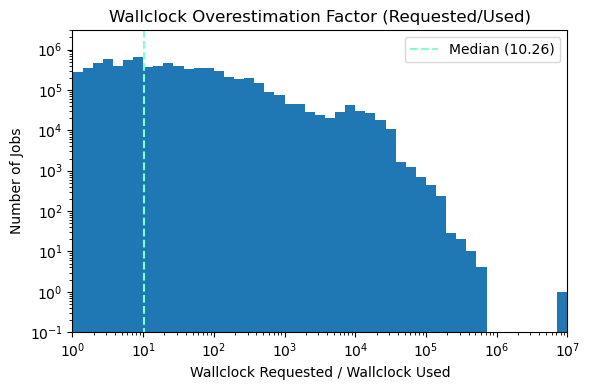

In [253]:
plt.figure(figsize=(6,4))
plt.hist(filtered_df[filtered_df.wallclock_used_seconds > 0].wc_factor, bins=np.logspace(0,7,50))
med_factor = filtered_df[filtered_df.wallclock_used_seconds > 0].wc_factor.median()
plt.vlines(med_factor,0,3000000, color = 'aquamarine', linestyle = '--', label=f"Median ({med_factor:.2f})")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim([1,10000000])
plt.ylim([.1,3000000])
plt.xlabel('Wallclock Requested / Wallclock Used')
plt.ylabel('Number of Jobs')
plt.title('Wallclock Overestimation Factor (Requested/Used)')
plt.tight_layout()
#plt.savefig('wallclock_overestimation_factor.jpg',dpi=300)
plt.show()

In [54]:
filtered_df['wait_time'] = (filtered_df.start_time - filtered_df.submit_time).apply(lambda x: x.total_seconds())

/var/folders/cy/yhfymg2j61gfl448mb_195qxlvt1vt/T/ipykernel_96512/206475875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['wait_time'] = (filtered_df.start_time - filtered_df.submit_time).apply(lambda x: x.total_seconds())


In [56]:
filtered_df['wallclock_req_seconds'] = filtered_df['wallclock_req'].apply(lambda x: x.total_seconds())

/var/folders/cy/yhfymg2j61gfl448mb_195qxlvt1vt/T/ipykernel_96512/3212569425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['wallclock_req_seconds'] = filtered_df['wallclock_req'].apply(lambda x: x.total_seconds())


In [147]:
def bin_wallclock_req(v):
    if v <= .1:
        return 0 #"[0,10 m)"
    elif (v > .1) and (v <= 1):
        return 1 #"[10,30 m)"
    elif (v > 1) and (v <= 10):
        return 2 #"[30 m,1 hr)"
    elif (v > 10) and (v <= 100):
        return 3 #"[1,2 hr)"\
    else:
        return 4

In [148]:
filtered_df["wallclock_req_binned"] = (filtered_df.wallclock_req_seconds / 3600).apply(bin_wallclock_req)

/var/folders/cy/yhfymg2j61gfl448mb_195qxlvt1vt/T/ipykernel_96512/3844773637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["wallclock_req_binned"] = (filtered_df.wallclock_req_seconds / 3600).apply(bin_wallclock_req)


In [149]:
avg_wait_time = dict()
for idx, grp in filtered_df.groupby('wallclock_req_binned'):
    avg_wait_time[idx] = grp.wait_time.mean() / 3600

In [150]:
from scipy.optimize import curve_fit

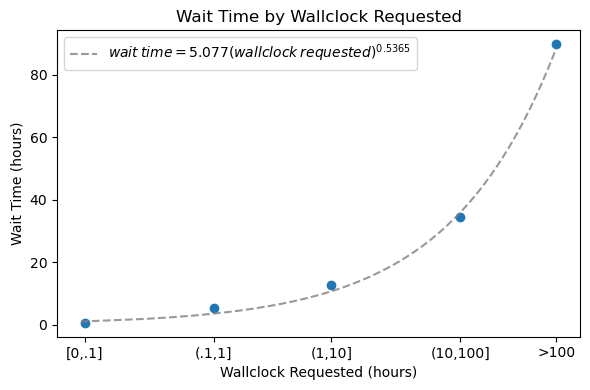

In [229]:
plt.figure(figsize=(6,4))
x = np.array([0.0537,.5115,4.02,38.42,206.1])
y = np.array(list(avg_wait_time.values()))

x_ = np.linspace(0.05,206,2000)
y_ = 5.077028*x_**.5365035

plt.scatter(x,y)
plt.plot(x_,y_,linestyle='--',color='grey',alpha=0.8,label='$wait\:time=5.077(wallclock\:requested)^{0.5365}$')

plt.xscale('log')
#plt.yscale('log')
plt.xticks(x,labels=['[0,.1]','(.1,1]','(1,10]','(10,100]','>100'])
plt.xlabel('Wallclock Requested (hours)')
plt.ylabel('Wait Time (hours)')
plt.title('Wait Time by Wallclock Requested')
plt.minorticks_off()
plt.tight_layout()
plt.legend()
#plt.savefig('waittime_by_wallclock_req.jpg',dpi=300)

In [189]:
filtered_df[filtered_df.wallclock_req_seconds < .1*3600].wallclock_req_seconds.mean() / 3600

0.053722662915347844

In [190]:
filtered_df[filtered_df.wallclock_req_seconds.between(.1*3600,3600,inclusive='right')].wallclock_req_seconds.mean() / 3600

0.5114917548939671

In [191]:
filtered_df[filtered_df.wallclock_req_seconds.between(3600,36000,inclusive='right')].wallclock_req_seconds.mean() / 3600

4.021349111120306

In [192]:
filtered_df[filtered_df.wallclock_req_seconds.between(36000,360000,inclusive='right')].wallclock_req_seconds.mean() / 3600

38.42692376973019

In [193]:
filtered_df[filtered_df.wallclock_req_seconds > 360000].wallclock_req_seconds.mean() / 3600

206.12755237474113

In [233]:
filtered_df[filtered_df.hours_used == filtered_df.hours_used.max()]

,user,account,partition,nodes_req,processors_req,wallclock_req,qos,gpus_requested,name,submit_time,...,end_time,work_dir,submit_line,req_mem,wallclock_used_seconds,node_hours_binned,wc_factor,wait_time,wallclock_req_seconds,wallclock_req_binned
6117367,mdelchini,hpc4th,long,250,9000,10 days,normal,0,HFIR-CC,2021-04-12 10:51:41,...,2021-04-25 17:44:18,/lustre/eaglefs/scratch/mdelchini/Nek5000/run/...,None,0n,864022.0,long,0.999975,283935.0,864000.0,4


In [234]:
filtered_df.hours_used.max()

60001.527

In [254]:
filtered_df[filtered_df.wc_factor == filtered_df[filtered_df.wallclock_used_seconds > 0].wc_factor.max()]

,user,account,partition,nodes_req,processors_req,wallclock_req,qos,gpus_requested,name,submit_time,...,end_time,work_dir,submit_line,req_mem,wallclock_used_seconds,node_hours_binned,wc_factor,wait_time,wallclock_req_seconds,wallclock_req_binned
1081,lambk,csc000,ddn,8,8,365 days,normal,0,bash,2018-11-14 22:59:27,...,2018-11-14 22:59:31,/scratch/lambk/DDN_BM/ior/nodemap,None,0n,4.0,short,7884000.0,0.0,31536000.0,4


In [152]:
avg_wait_time

{0: 0.6152947631770836,
 1: 5.4768263194531,
 2: 12.642329650994107,
 3: 34.36002803704336,
 4: 89.79769406366613}

In [280]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [287]:
dub_f_df = filtered_df[~filtered_df.wallclock_used_seconds.isna() & ~filtered_df.wallclock_req_seconds.isna()]

In [307]:
rmse = mean_squared_error(dub_f_df.wallclock_used_seconds,dub_f_df.wallclock_req_seconds/3, squared=False)

In [317]:
start_date=pd.Timestamp("2019-01-01")
end_date=pd.Timestamp("2022-12-31")


In [318]:
date_list = pd.date_range(start='01-01-2019', end='12-31-2022', freq=pd.Timedelta('6 days'))

In [331]:
dfs = []
for date in date_list:
    df = dub_f_df[dub_f_df.submit_time.between(date,date + pd.Timedelta(days=1))]
    dfs.append(df)

In [332]:
total_df = pd.concat(dfs)

In [333]:
for i in np.arange(1,30,.1):
    rmse = mean_squared_error(total_df.wallclock_used_seconds,total_df.wallclock_req_seconds/i, squared=False)
    print(f'{i:.1f}', f'{rmse/3600:.2f}')

1.0 25.92
1.1 23.35
1.2 21.27
1.3 19.55
1.4 18.13
1.5 16.93
1.6 15.92
1.7 15.07
1.8 14.35
1.9 13.73
2.0 13.21
2.1 12.76
2.2 12.37
2.3 12.04
2.4 11.76
2.5 11.52
2.6 11.31
2.7 11.14
2.8 10.99
2.9 10.86
3.0 10.75
3.1 10.66
3.2 10.58
3.3 10.52
3.4 10.47
3.5 10.42
3.6 10.39
3.7 10.36
3.8 10.34
3.9 10.32
4.0 10.31
4.1 10.30
4.2 10.30
4.3 10.30
4.4 10.30
4.5 10.30
4.6 10.31
4.7 10.32
4.8 10.33
4.9 10.34
5.0 10.35
5.1 10.36
5.2 10.38
5.3 10.39
5.4 10.41
5.5 10.42
5.6 10.44
5.7 10.45
5.8 10.47
5.9 10.49
6.0 10.51
6.1 10.52
6.2 10.54
6.3 10.56
6.4 10.57
6.5 10.59
6.6 10.61
6.7 10.63
6.8 10.64
6.9 10.66
7.0 10.68
7.1 10.69
7.2 10.71
7.3 10.73
7.4 10.74
7.5 10.76
7.6 10.77
7.7 10.79
7.8 10.80
7.9 10.82
8.0 10.84
8.1 10.85
8.2 10.87
8.3 10.88
8.4 10.89
8.5 10.91
8.6 10.92
8.7 10.94
8.8 10.95
8.9 10.96
9.0 10.98
9.1 10.99
9.2 11.00
9.3 11.02
9.4 11.03
9.5 11.04
9.6 11.05
9.7 11.07
9.8 11.08
9.9 11.09
10.0 11.10
10.1 11.11
10.2 11.12
10.3 11.14
10.4 11.15
10.5 11.16
10.6 11.17
10.7 11.18
10.8 11.19
1

In [308]:
rmse /3600

9.075956585778659

In [338]:
filtered_df.wallclock_req_seconds

73025       172800.0
73026       172800.0
73027       172800.0
73028       172800.0
73029       172800.0
              ...   
10824831    172800.0
10824832    172800.0
10824833    172800.0
10824834    172800.0
10824835    172800.0
Name: wallclock_req_seconds, Length: 7936388, dtype: float64